## NYPD Data

### Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

### Data Import

In [2]:
pickle_path = ('../raw_data/clean.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

### Sample Selection

In [3]:
inf = df['period'] > datetime(2016, 10, 1, 0, 0, 0)
sup = df['period'] < datetime(2016, 11, 1, 0, 0, 0)
sample = df[ inf & sup ]

In [4]:
sample = sample[sample['precinct_number']==75]

In [5]:
sample['longitude'].min(), sample['longitude'].max(), sample['latitude'].min(), sample['latitude'].max() 

(-73.990914183, -73.857278418, 40.642278393000005, 40.692681179000004)

In [6]:
del df

In [7]:
sample.shape

(1252, 20)

### DataGenerator

In [8]:
import tensorflow as tf

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, lat_meters=100, lon_meters=100, *args, **kwargs):
        self.df = df
        self.batch_size = batch_size
        self.indices = np.arange(len(self.df))
        self.shuffle = shuffle
        self.lat_meters = lat_meters
        self.lon_meters = lon_meters
        self.on_epoch_end()

    def __len__(self):
        """
        Return the number of batches so the generator knows how many batches
        it should generate for each epoch
        """
        return len(df) // self.batch_size
​
  def __getitem__(self, i):
    """
    Return the i-th batch
    """
    batch_indices = self.indices[i * self.batch_size:(i + 1) * self.batch_size]
    batch = self.df.iloc[batch_indices] 
    return self.__get_data(batch)
​
  def __get_data(self, batch):
    X = from_coord_to_matrix(batch, lat_meters=self.lat_meters, lon_meters=self.lon_meters)
    y = from_coord_to_matrix(batch, lat_meters=self.lat_meters, lon_meters=self.lon_meters) # à changer
    return X, y
​
  def on_epoch_end(self):
    self.indices = np.arange(len(self.df))
    if self.shuffle == True:
        np.random.shuffle(self.indices)

SyntaxError: invalid character in identifier (<ipython-input-8-644b1b58413f>, line 2)

In [9]:
BATCH_SIZE = 2
​
datagen = CustomDataGenerator(df, batch_size=BATCH_SIZE)
p, q = datagen.__getitem__(3)
print(p.shape)
print(q.shape)

SyntaxError: invalid character in identifier (<ipython-input-9-a3a196b3685a>, line 2)

### Lat - Long to Array

In [10]:
def from_meters_to_coords(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth’s radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    return latO, lonO

In [12]:
def from_coord_to_matrix(df, lat_meters, lon_meters):
    """
    outputs the 3D matrix of all coordinates for a given bucket height and width in meters
    """
    df=df.copy()
    #add 'time_index' column to df
    ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
    df['time_index'] = df['period'].map(ind)
    
    #initiate matrix
    #40.49611539518921, 40.91553277600008, -74.25559136315213,-73.70000906387347) : NYC boundaries
    #([40.56952999448672, 40.73912795313436],[-74.04189660705046, -73.83355923946421]) : brooklyn boundaries
    #[40.6218192717505, 40.6951504231971],[-73.90404639808888, -73.83559344190869]) :precinct 75 boundaries
    
    grid_offset = np.array([ -40.692681179000004,  -73.990914183,0]) # Where do you start
    #from meters to lat/lon step
    lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters )
    grid_spacing = np.array([lat_spacing , lon_spacing,1]) # What's the space you consider (euclidian here)
     
    
    #get points coordinates
    coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                   in zip(df['latitude'],df['longitude'],df['time_index'])])
    
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0]
    Y = indexes[:,1]
    Z = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((X.max()+1, Y.max()+1, Z.max()+1))
   
    
    a[X, Y, Z]=1
    
    return a, a.shape[1], a.shape[2]

In [13]:
img, lat_size, lon_size = from_coord_to_matrix(sample, 10, 25)

In [14]:
img.shape

(562, 457, 578)

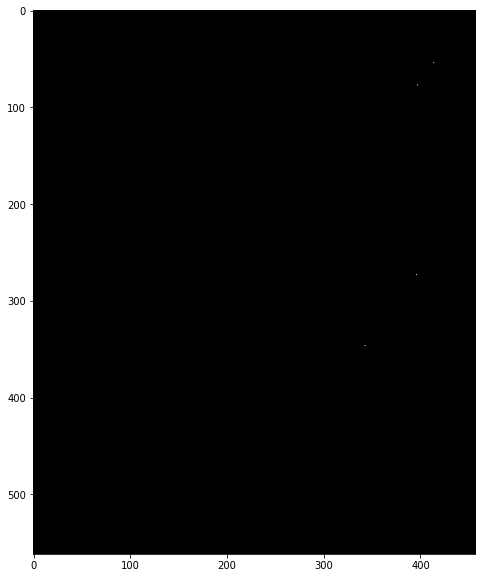

In [15]:
plt.figure(figsize=(10, 10))

plt.imshow(img[:,:,10], cmap='gray');

### Stacking

In [ ]:
def func(input_array, X_step, X_timeframe, y_step, y_timeframe):

total_observations = len(input_array) / X_timeframe + y_timeframe 
# if X_time + y_time = 10, and array is 1k, then total num is 100
X_percentage_of_obs = X_timeframe / (X_timeframe + y_timeframe)

len(X_timeframe) = (X_timeframe + y_timeframe) * X_timeframe
# total_timeframe_observed.append(input array / X_timeframe + y_timeframe) # one observation

for timeframe in total_timeframes_observed[ : X_timeframe]:
    n = number_of_images / X_step
    
for timeframe in total_timeframes_observed[X_timeframe : X_timeframe + y_timeframe]:
    y_timeframe / y_step


In [ ]:
def func(input array, 24, 7, 3, 3):
    
total_observations = 1_000 / 10 # 100 total observations

for timeframe in total_timeframes_observed[ : X_timeframe]:
    n = number_of_images / X_step
    
for timeframe in total_timeframes_observed[X_timeframe : X_timeframe + y_timeframe]:
    y_timeframe / y_step

### Plotting Array (with and w/o Gaussian filter)

**Gaussian Filter**

- **sigma** = represents st. dv. for each axis of img (lat, long, time)

In [16]:
img3D_conv = gaussian_filter(img, sigma=(2, 2, 2))

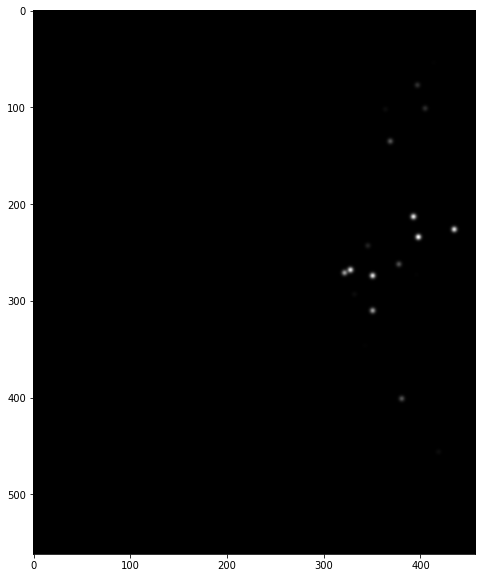

In [17]:
plt.figure(figsize=(10, 10))

plt.imshow(img3D_conv[:,:,4], cmap='gray');

### Splitting into X and y

In [ ]:
def get_X(matrix, nb_hours):
    
    pass

In [ ]:
def get_y():
    pass

In [27]:
def get_observation_target(img3D_conv, x_length, y_length):
    '''
    output an observation of x_length consecutive images and the y_length next images as the target
    '''
    position = np.random.randint(0, img3D_conv.shape[0] - (x_length + y_length))
    #regroup_by
    observation = img3D_conv[:,:,position:position + x_length]
    target = img3D_conv[:,:,position + x_length:position + (x_length + y_length)]

    return observation, target

### Subsampling to get multiple X and y

In [28]:
def get_X_y(img3D_conv, number_of_observations, x_length, y_length):
    '''
    outputs n observations and their associated targets
    '''
    X = []
    y = []
    
    for n in range(number_of_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv, x_length, y_length)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [ ]:
x_length = 24
y_length= 3

X, y = get_X_y(img3D_conv, 500, x_length, y_length)

In [ ]:
del img, img3D_conv, inf, sup, sample

In [ ]:
X.shape

## Model

### Imports

In [ ]:
# Train, test, split
from sklearn.model_selection import train_test_split

# Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### Train, test, split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
del X,y

### Model

In [ ]:
def init_model(x_length, y_length, lat_size, lon_size):
    print('initializing model')
    model = models.Sequential()
    
    print('adding conv3D 1')
    model.add(layers.Conv3D(64, kernel_size = 10, activation = 'relu', padding='same',
                            input_shape = (lat_size, lon_size, x_length, 1)))
    model.add(layers.MaxPooling3D(2))

    #print('adding conv3D 2')
    #model.add(layers.Conv3D(128, kernel_size = 5, activation = 'relu', padding='same'))
    #model.add(layers.MaxPooling3D(2))

    #print('adding conv3D 3')
    #model.add(layers.Conv3D(64, kernel_size = 3, activation = 'relu', padding='same'))
    #model.add(layers.MaxPooling3D(2,))     

    print('flattening')
    model.add(layers.Flatten())
    
    print('adding dense layer 1')
    model.add(layers.Dense(5_000, activation = 'relu'))
    
    print('adding dense layer 2')
    model.add(layers.Dense(50_000, activation = 'relu'))
    
    print('adding dense layer 3')
    model.add(layers.Dense(lat_size * lon_size, activation = 'relu'))
    
    print('adding dense layer 4')
    model.add(layers.Dense(lat_size * lon_size * y_length/2, activation = 'relu'))
    
    #print('adding dense layer 2')
    #model.add(layers.Dropout(rate=0.5))

    print('adding final dense layer')
    model.add(layers.Dense(y_length * lat_size * lon_size, activation = 'relu'))
    
    print('Reshaping')
    model.add(layers.Reshape((lat_size, lon_size, y_length)))
    
    print('compiling')
    model.compile(loss = 'mse',
                  optimizer = 'adam',
                  metrics = 'mae')
    print('Done !')
    
    return model

### Running Model (Instance, Early Stopping, Fit and Evaluate)

**Reminders**

**batch_size:** no. of data used to compute error between y_pred and y_true each time weights of neural network updated (use 16 or 32)

**epoch:** once all data has been used once to update the weights

In [ ]:
model = init_model(x_length,y_length, lat_size, lon_size)

In [ ]:
model.summary()

In [ ]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                      batch_size = 32, 
                      epochs = 2,
                      validation_split = 0.3,
                      callbacks = es)

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['val_loss'])

In [ ]:
plt.plot(history.history['val_mae'])

In [ ]:
print(model.evaluate(X_test, y_test))

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred = flatten

In [ ]:
y_pred.reshape(y_length, lat_size, lon_size)

## From coord to map

In [ ]:
def from_matrix_to_coord(matrix, lat_meters, lon_meters):
        """
        gives back the coordinates from a 3D matrix for a given bucket height and width
        """
        results = []
        for observation in matrix:
            # Where do you start
            grid_offset = np.array([0, -40.91553277600008,  -74.25559136315213,])

            #from meters to lat/lon step
            lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters)

            # What's the space you consider (euclidian here)
            grid_spacing = np.array([1, lat_spacing, lon_spacing])

            indexes = np.argwhere(observation)
            #print(indexes.shape)
            # index : coords de mes crimes dans mon np array
            result = grid_offset + indexes * grid_spacing
            results.append(result)
        return np.array(results)

In [ ]:
y_pred_notsure = np.where((y_train>5*10**(-4)) & (y_train<5*10**(-3)), y_train, 0)
y_pred_middle = np.where((y_train>5*10**(-3)) & (y_train<1*10**(-2)), y_train, 0)
y_pred_sure = np.where(y_train>1*10**(-2), y_train, 0)

#y_pred_notsure = np.where((y_pred>5*10**(-3)) & (y_pred<1*10**(-2)), y_pred, 0)
#y_pred_middle = np.where((y_pred>1*10**(-2)) & (y_pred<1.8*10**(-2)), y_pred, 0)
#y_pred_sure = np.where(y_pred>1.8*10**(-2), y_pred, 0)

In [ ]:
coords_not_sure = from_matrix_to_coord(y_pred_notsure, 200, 200)
coords_middle = from_matrix_to_coord(y_pred_middle, 200, 200)
coords_sure = from_matrix_to_coord(y_pred_sure, 200, 200)

In [ ]:
coords_back_not_sure_df = pd.DataFrame(coords_not_sure[0], columns=['image', 'lat', 'lon'])
coords_back_not_sure_df['right_lat'] = -coords_back_not_sure_df['lat']

coords_middle_df = pd.DataFrame(coords_middle[0], columns=['image', 'lat', 'lon'])
coords_middle_df['right_lat'] = -coords_middle_df['lat']

coords_back_sure_df = pd.DataFrame(coords_sure[0], columns=['image', 'lat', 'lon'])
coords_back_sure_df['right_lat'] = -coords_back_sure_df['lat']

In [ ]:
last_image_not_sure = coords_back_not_sure_df[coords_back_not_sure_df['image']==2.0]
last_image_middle = coords_middle_df[coords_middle_df['image']==2.0]
last_image_sure = coords_back_sure_df[coords_back_sure_df['image']==2.0]

In [ ]:
import seaborn as sns

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlim(left=-74.25559136315213, right=-73.70000906387347)
ax.set_ylim(bottom = 40.49611539518921, top=40.91553277600008)
sns.scatterplot(x='lon', y='right_lat', data=last_image_not_sure, s=2, ax=ax)
sns.scatterplot(x='lon', y='right_lat', data=last_image_middle, s=2, ax=ax)
sns.scatterplot(x='lon', y='right_lat', data=last_image_sure, s=2, ax=ax)
plt.legend()

In [ ]:
#modèle clairement pourri car il indique des crimes sur staten island
#voir baseline modèle (on est en dessous)